<a href="https://colab.research.google.com/github/MattHodgman/ProteoHist/blob/main/tumor_vs_normal_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify whether a patch is tumor or normal

### Load data

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [ ]:
tumor_path = '/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/tumor/FEATURES_DIRECTORY/h5_files/'
normal_path = '/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/normal/FEATURES_DIRECTORY/h5_files/'
both_path = '/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/both/FEATURES_DIRECTORY/h5_files/'

In [ ]:
def make_df(path, group):
  files = os.listdir(path)
  ids = pd.DataFrame([id[:-3] for id in files], columns=['id'])
  df_ids = pd.DataFrame(ids)
  df_ids[['sample', 'id']] = df_ids['id'].str.rsplit('-', 1, expand=True)
  df_ids['file'] = df_ids['sample'] + '-' + df_ids['id'] + '.h5'
  df_ids['group'] = group

  return df_ids

In [ ]:
df = pd.concat([make_df(normal_path, 'normal'), make_df(tumor_path, 'tumor'), make_df(both_path, 'both')])
df['class'] = df['group'].map({'normal' : 0, 'tumor' : 1, 'both' : 2})

In [ ]:
df2 = df[df['group'] != 'both'].groupby('sample').first().reset_index()

In [ ]:
def read_features(path, file_name, class_label):
  f = h5py.File(f'{path}/{file_name}')
  x = np.array(f['features'])
  x = np.hstack((np.full((x.shape[0], 1), class_label), x))
  return x

def get_X(df):
  X = np.empty((0,1025))
  for index, row in df.iterrows():
    group = row['group']
    path = f'/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/{group}/FEATURES_DIRECTORY/h5_files'
    x = read_features(path, row['file'], row['class'])
    X = np.vstack((X, x))
  
  return X

In [ ]:
X = get_X(df2)

In [ ]:
y = X[:,0]

In [ ]:
X = np.delete(X, 0, axis=1)

### Sample Data

In [ ]:
model = LogisticRegression(penalty='l1', max_iter=100, solver='saga')

fs = []
ss = []
auc = []
f1 = []
auprc = []

for f in range(100, 1024, 200):
  for s in range(1000, 10000, 2000):

    # sample data
    idx = np.random.choice(X.shape[1], f) 
    X_sample = X[:,idx] # randomly sample features
    X_sample, y_sample = resample(X_sample, y, n_samples=s, replace=False) # randomly sample patches
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=0)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, y_train) # fit model

    # test and report
    auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    f1.append(f1_score(y_test, model.predict(X_test)))
    auprc.append(average_precision_score(y_test, model.predict_proba(X_test)[:,1]))
    fs.append(f)
    ss.append(s)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

In [ ]:
# plot
df_res = pd.DataFrame(list(zip(auc, auprc, f1, fs, ss)), columns=['auc','auprc','f1','n_features','n_samples'])

Text(0.5, 0, 'number of features')

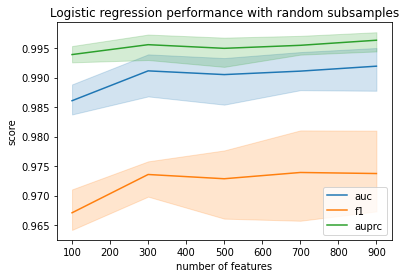

In [ ]:
sns.lineplot(data=df_res, x='n_features', y='auc', label='auc').set_ylabel('score')
sns.lineplot(data=df_res, x='n_features', y='f1', label='f1').set_title('Logistic regression performance with random subsamples')
sns.lineplot(data=df_res, x='n_features', y='auprc', label='auprc').set_xlabel('number of features')

Text(0.5, 0, 'number of patches')

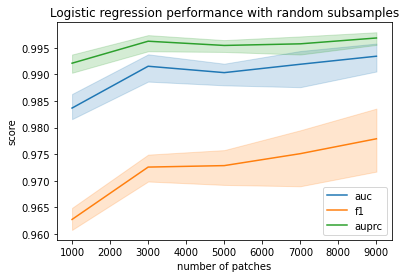

In [ ]:
sns.lineplot(data=df_res, x='n_samples', y='auc', label='auc').set_ylabel('score')
sns.lineplot(data=df_res, x='n_samples', y='f1', label='f1').set_title('Logistic regression performance with random subsamples')
sns.lineplot(data=df_res, x='n_samples', y='auprc', label='auprc').set_xlabel('number of patches')

In [ ]:
# average number of patches per slide
(9000 / df2['file'].nunique()) / (X.shape[0] / df2['file'].nunique())

0.03805609468356357

### Model

In [ ]:
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split #, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=0)

#### Logistic Regression

In [ ]:
model = LogisticRegression(penalty='l1', max_iter=100, solver='saga')

In [ ]:
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(penalty='l1', solver='saga')

In [ ]:
print('AUC', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print('AUPRC', average_precision_score(y_test, model.predict_proba(X_test)[:,1]))
print('F1', f1_score(y_test, model.predict(X_test)))

AUC 0.9629020467836258
AUPRC 0.9875495187618936
F1 0.9460043196544277


#### Balanced Random Forest

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
model = BalancedRandomForestClassifier()

In [ ]:
model.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
print('AUC', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print('AUPRC', average_precision_score(y_test, model.predict_proba(X_test)[:,1]))
print('F1', f1_score(y_test, model.predict(X_test)))

#### Multi-Layer Perception

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(500, 100, 100, 20))
model.fit(X_train, y_train)
print('AUC', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print('AUPRC', average_precision_score(y_test, model.predict_proba(X_test)[:,1]))
print('F1', f1_score(y_test, model.predict(X_test)))

#### Grid Search Cross Validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define hyper-parameters to search
params_rf = {
    'n_estimators' : [100, 200, 500, 1000],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 10, 20],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 5, 10],
    'max_features' : ['sqrt', 'log2'],
    'n_jobs' : [-1]
}
model = BalancedRandomForestClassifier()

# Find optimal hyper-parameters using cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='f1', refit='f1')
grid.fit(X_train, y_train)

# Print results
print('GRID SEARCH CROSS VALIDATION RESULTS ON TRAINING DATA:')
print(sorted(grid.cv_results_.keys()))
print('Best score:')
print(grid.best_score_)
print('Best parameters:')
print(grid.best_params_)

# Test and get metrics
print('TEST RESULTS:')
try:
    print('AUC', roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:,1]))
    print('AUPRC', average_precision_score(y_test, grid.best_estimator_.predict_proba(X_test)[:,1]))
    print('F1', f1_score(y_test, grid.best_estimator_.predict(X_test)))
except:
    print('F1', f1_score(y_test, grid.best_estimator_.predict(X_test)))

grid.best_estimator_
